In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def process_clips_for_correlation_test(clips, true_counts, augmentation_labels, model_path):
    """
    Process clips to extract confidence and variance metrics for correlation analysis
    
    Parameters:
    - clips: List of video file paths or clip objects
    - true_counts: List of ground truth counts (same length as clips)
    - augmentation_labels: List of augmentation types ['None', 'blur', 'contrast', 'brightness', etc.]
    - model_path: Path to YOLO model weights (instead of model object)
    
    Returns:
    - results_df: DataFrame with all metrics for analysis
    """
    
    clip_results = []
    
    for i, (clip_path, true_count, augmentation) in enumerate(zip(clips, true_counts, augmentation_labels)):
        print(f"Processing clip {i+1}/{len(clips)}: {clip_path} ({augmentation})")
        
        # Initialize lists for this clip
        frame_detection_counts = []
        frame_confidences_all = []
        frame_variances = []
        frame_mean_confidences = []
        unique_track_ids = set()
        
        # Run YOLO tracking on the entire video
        try:
            # Create fresh model instance for each clip to avoid state contamination
            from ultralytics import YOLO
            yolo_model = YOLO(model_path)
            
            yolo_results = yolo_model.track(
                source=clip_path,
                conf=0.7,
                iou=0.45,
                save=False,
                stream=False,
                persist=True,
            )
            
            frame_count = 0
            
            for frame_result in yolo_results:
                # Extract confidences and IDs from this frame
                if hasattr(frame_result, 'boxes') and frame_result.boxes is not None:
                    # Get confidences
                    confidences = frame_result.boxes.conf.cpu().numpy()
                    
                    # Get tracking IDs if available
                    if hasattr(frame_result.boxes, 'id') and frame_result.boxes.id is not None:
                        track_ids = frame_result.boxes.id.cpu().numpy()
                        unique_track_ids.update(track_ids.astype(int))
                    
                else:
                    confidences = np.array([])
                
                # Store frame-level metrics
                frame_detection_count = len(confidences)
                frame_detection_counts.append(frame_detection_count)
                
                if len(confidences) > 0:
                    frame_mean_conf = np.mean(confidences)
                    frame_var_conf = np.var(confidences) if len(confidences) > 1 else 0.0
                    frame_confidences_all.extend(confidences.tolist())
                else:
                    frame_mean_conf = 0.0
                    frame_var_conf = 0.0
                
                frame_mean_confidences.append(frame_mean_conf)
                frame_variances.append(frame_var_conf)
                
                frame_count += 1
                
        except Exception as e:
            print(f"  Error processing clip: {e}")
            # Fallback to empty results
            frame_count = 0
            unique_track_ids = set()
            frame_detection_counts = [0]
            frame_confidences_all = [0]
            frame_variances = [0]
            frame_mean_confidences = [0]
        
        # Calculate clip-level metrics
        tracking_count = len(unique_track_ids)  # This is the key metric - unique objects tracked
        mean_detection_count = np.mean(frame_detection_counts)  # Average detections per frame
        
        clip_metrics = {
            'clip_index': i,
            'clip_path': clip_path,
            'augmentation': augmentation,
            'is_good_clip': augmentation == 'None',
            'true_count': true_count,
            'total_frames': frame_count,
            
            # Tracking-based count metrics (PRIMARY)
            'tracking_count': tracking_count,
            'tracking_accuracy': 1 - abs(tracking_count - true_count) / true_count if true_count > 0 else 0,
            'tracking_error': abs(tracking_count - true_count),
            'relative_tracking_error': abs(tracking_count - true_count) / true_count if true_count > 0 else float('inf'),
            
            # Frame-based detection metrics (SECONDARY - for comparison)
            'mean_detection_count': mean_detection_count,
            'std_detection_count': np.std(frame_detection_counts),
            'detection_cv': np.std(frame_detection_counts) / mean_detection_count if mean_detection_count > 0 else 0,
            'detection_accuracy': 1 - abs(mean_detection_count - true_count) / true_count if true_count > 0 else 0,
            'detection_error': abs(mean_detection_count - true_count),
            
            # Confidence metrics (traditional monitoring)
            'mean_confidence': np.mean(frame_mean_confidences),
            'std_confidence': np.std(frame_mean_confidences),
            'overall_mean_confidence': np.mean(frame_confidences_all) if frame_confidences_all else 0,
            'overall_std_confidence': np.std(frame_confidences_all) if len(frame_confidences_all) > 1 else 0,
            
            # Variance metrics (your approach)
            'mean_variance': np.mean(frame_variances),
            'std_variance': np.std(frame_variances),
            'max_variance': np.max(frame_variances),
            'variance_90th_percentile': np.percentile(frame_variances, 90),
            'variance_cv': np.std(frame_variances) / np.mean(frame_variances) if np.mean(frame_variances) > 0 else 0,
            
            # Store raw data for Bayesian monitor
            'raw_variances': frame_variances.copy()
        }
        
        clip_results.append(clip_metrics)
        
        print(f"  Augmentation: {augmentation}")
        print(f"  Frames: {frame_count}")
        print(f"  Unique tracked objects: {tracking_count} (true: {true_count})")
        print(f"  Tracking accuracy: {clip_metrics['tracking_accuracy']:.3f}")
        print(f"  Mean detections/frame: {clip_metrics['mean_detection_count']:.2f}")
        print(f"  Mean confidence: {clip_metrics['mean_confidence']:.3f}")
        print(f"  Mean variance: {clip_metrics['mean_variance']:.6f}")
        print()
    
    return pd.DataFrame(clip_results)

def run_correlation_analysis(results_df):
    """
    Run correlation analysis between different metrics and count accuracy
    """
    print("="*60)
    print("CORRELATION ANALYSIS: VARIANCE vs CONFIDENCE MONITORING")
    print("="*60)
    
    # Define metrics to test
    variance_metrics = [
        ('mean_variance', 'Mean Confidence Variance'),
        ('variance_90th_percentile', '90th Percentile Variance'),
        ('max_variance', 'Maximum Variance'),
        ('variance_cv', 'Variance Coefficient of Variation')
    ]
    
    confidence_metrics = [
        ('mean_confidence', 'Mean Confidence Score'),
        ('overall_mean_confidence', 'Overall Mean Confidence'),
        ('std_confidence', 'Confidence Standard Deviation')
    ]
    
    target_metrics = [
        ('tracking_accuracy', 'Tracking Accuracy'),
        ('relative_tracking_error', 'Relative Tracking Error (higher = worse)'),
        ('detection_accuracy', 'Detection Accuracy (frame-based)'),
        ('detection_cv', 'Detection Count Variability')
    ]
    
    correlation_results = {}
    
    print("\nVARIANCE-BASED METRICS:")
    print("-" * 40)
    
    for var_metric, var_name in variance_metrics:
        print(f"\n{var_name}:")
        for target_metric, target_name in target_metrics:
            if target_metric in results_df.columns:
                # Remove any infinite values
                valid_data = results_df[[var_metric, target_metric]].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(valid_data) >= 3:
                    x = valid_data[var_metric]
                    y = valid_data[target_metric]
                    
                    pearson_r, pearson_p = pearsonr(x, y)
                    spearman_r, spearman_p = spearmanr(x, y)
                    
                    correlation_results[f"{var_metric}_vs_{target_metric}"] = {
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n_samples': len(valid_data),
                        'metric_type': 'variance'
                    }
                    
                    print(f"  vs {target_name}:")
                    print(f"    Pearson:  r = {pearson_r:6.3f}, p = {pearson_p:.3f}")
                    print(f"    Spearman: r = {spearman_r:6.3f}, p = {spearman_p:.3f}")
    
    print("\n\nCONFIDENCE-BASED METRICS (Traditional Monitoring):")
    print("-" * 50)
    
    for conf_metric, conf_name in confidence_metrics:
        print(f"\n{conf_name}:")
        for target_metric, target_name in target_metrics:
            if target_metric in results_df.columns:
                valid_data = results_df[[conf_metric, target_metric]].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(valid_data) >= 3:
                    x = valid_data[conf_metric]
                    y = valid_data[target_metric]
                    
                    pearson_r, pearson_p = pearsonr(x, y)
                    spearman_r, spearman_p = spearmanr(x, y)
                    
                    correlation_results[f"{conf_metric}_vs_{target_metric}"] = {
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n_samples': len(valid_data),
                        'metric_type': 'confidence'
                    }
                    
                    print(f"  vs {target_name}:")
                    print(f"    Pearson:  r = {pearson_r:6.3f}, p = {pearson_p:.3f}")
                    print(f"    Spearman: r = {spearman_r:6.3f}, p = {spearman_p:.3f}")
    
    return correlation_results

def plot_key_correlations(results_df, save_plots=True):
    """
    Create scatter plots for the most important correlations
    """
    # Define colors for different augmentations
    augmentation_colors = {
        'None': 'green',
        'blur': 'red', 
        'contrast': 'orange',
        'brightness': 'purple',
        'noise': 'brown',
        'occlusion': 'blue'
    }
    
    # Get colors for each clip
    colors = [augmentation_colors.get(aug, 'gray') for aug in results_df['augmentation']]
    
    # Create first figure: Main correlation plots
    fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mean Variance vs Tracking Accuracy
    ax = axes1[0]
    scatter1 = ax.scatter(results_df['mean_variance'], results_df['tracking_accuracy'], 
                         c=colors, s=100, alpha=0.7)
    
    # Add correlation info
    r, p = pearsonr(results_df['mean_variance'], results_df['tracking_accuracy'])
    ax.text(0.05, 0.15, f'r = {r:.3f}\np = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Mean Confidence Variance')
    ax.set_ylabel('Tracking Accuracy')
    ax.set_title('Variance-Based Monitoring vs Tracking Performance')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Mean Confidence vs Tracking Accuracy
    ax = axes1[1]
    scatter2 = ax.scatter(results_df['mean_confidence'], results_df['tracking_accuracy'], 
                         c=colors, s=100, alpha=0.7)
    
    r, p = pearsonr(results_df['mean_confidence'], results_df['tracking_accuracy'])
    ax.text(0.05, 0.15, f'r = {r:.3f}\np = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Mean Confidence Score')
    ax.set_ylabel('Tracking Accuracy')
    ax.set_title('Traditional Confidence Monitoring vs Tracking Performance')
    ax.grid(True, alpha=0.3)
    
    # Add shared legend centered below both plots
    legend_elements = [plt.scatter([], [], c=color, s=100, label=aug_type, alpha=0.7) 
                      for aug_type, color in augmentation_colors.items() 
                      if aug_type in results_df['augmentation'].values]
    
    fig1.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_elements))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    if save_plots:
        plt.savefig('correlation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create second figure: Variance vs Tracking Error
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
    
    scatter3 = ax2.scatter(results_df['mean_variance'], results_df['tracking_error'], 
                          c=colors, s=100, alpha=0.7)
    
    r, p = pearsonr(results_df['mean_variance'], results_df['tracking_error'])
    ax2.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3f}', transform=ax2.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('Mean Confidence Variance')
    ax2.set_ylabel('Tracking Error (Absolute)')
    ax2.set_title('Variance vs Tracking Error')
    ax2.grid(True, alpha=0.3)
    
    # Add legend to upper right of second figure (moved away from correlation text)
    legend_elements2 = [plt.scatter([], [], c=color, s=100, label=aug_type, alpha=0.7) 
                       for aug_type, color in augmentation_colors.items() 
                       if aug_type in results_df['augmentation'].values]
    
    ax2.legend(handles=legend_elements2, loc='upper right')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig('variance_vs_error.png', dpi=300, bbox_inches='tight')
    plt.show()

def main_test_loop(clips, true_counts, augmentation_labels, model_path):
    """
    Main function to run the complete correlation test
    
    Parameters:
    - clips: List of video file paths
    - true_counts: List of ground truth counts (same order as clips)
    - augmentation_labels: List of augmentation types (same order as clips)
    - model_path: Path to YOLO model weights
    
    Example usage:
    clips = [
        'good_clip_1.mp4',
        'good_clip_2.mp4', 
        # ... more good clips
        'blurred_clip_1.mp4',
        'brightness_clip_1.mp4',
        # ... more bad clips
    ]
    
    true_counts = [25, 30, 22, 28, 35, 18,  # counts for good clips
                   25, 30, 22, 28]           # counts for bad clips (same objects, degraded)
    
    augmentation_labels = ['None', 'None', 'None', 'None', 'None', 'None',  # good clips
                          'blur', 'brightness', 'contrast', 'blur']         # bad clips
    
    model_path = "runs/detect/meatball_yolo/weights/best.pt"
    """
    
    print("Starting YOLO clip processing for correlation analysis...")
    print(f"Processing {len(clips)} clips with {len(true_counts)} ground truth counts")
    print(f"Augmentation types: {set(augmentation_labels)}")
    print(f"Model path: {model_path}")
    
    # Process all clips
    results_df = process_clips_for_correlation_test(clips, true_counts, augmentation_labels, model_path)
    
    # Run correlation analysis
    correlations = run_correlation_analysis(results_df)
    
    # Create plots
    plot_key_correlations(results_df)
    
    # Save DataFrame as pickle file
    results_df.to_pickle('correlation_results.pkl')
    
    print(f"\nDataFrame saved as: correlation_results.pkl")
    print(f"To reload: df = pd.read_pickle('correlation_results.pkl')")
    
    # Print augmentation-specific analysis
    print("\n" + "="*60)
    print("ANALYSIS BY AUGMENTATION TYPE")
    print("="*60)
    
    for aug_type in results_df['augmentation'].unique():
        aug_data = results_df[results_df['augmentation'] == aug_type]
        print(f"\n{aug_type.upper()} clips (n={len(aug_data)}):")
        print(f"  Mean tracking accuracy:   {aug_data['tracking_accuracy'].mean():.3f} (±{aug_data['tracking_accuracy'].std():.3f})")
        print(f"  Mean tracking count:      {aug_data['tracking_count'].mean():.1f} (±{aug_data['tracking_count'].std():.1f})")
        print(f"  Mean variance:            {aug_data['mean_variance'].mean():.6f} (±{aug_data['mean_variance'].std():.6f})")
        print(f"  Mean confidence:          {aug_data['mean_confidence'].mean():.3f} (±{aug_data['mean_confidence'].std():.3f})")
        print(f"  Detection CV (stability): {aug_data['detection_cv'].mean():.3f} (±{aug_data['detection_cv'].std():.3f})")
    
    # Print summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    # Find strongest correlations
    variance_corrs = [(k, v) for k, v in correlations.items() 
                     if v['metric_type'] == 'variance' and 'tracking_accuracy' in k]
    confidence_corrs = [(k, v) for k, v in correlations.items() 
                       if v['metric_type'] == 'confidence' and 'tracking_accuracy' in k]
    
    if variance_corrs:
        best_var = max(variance_corrs, key=lambda x: abs(x[1]['pearson_r']))
        print(f"Best variance correlation: {best_var[0]}")
        print(f"  r = {best_var[1]['pearson_r']:.3f}, p = {best_var[1]['pearson_p']:.3f}")
    
    if confidence_corrs:
        best_conf = max(confidence_corrs, key=lambda x: abs(x[1]['pearson_r']))
        print(f"Best confidence correlation: {best_conf[0]}")
        print(f"  r = {best_conf[1]['pearson_r']:.3f}, p = {best_conf[1]['pearson_p']:.3f}")
    
    # Count how many augmented clips were correctly identified as having issues
    good_clips = results_df[results_df['augmentation'] == 'None']
    bad_clips = results_df[results_df['augmentation'] != 'None']
    
    if len(good_clips) > 0 and len(bad_clips) > 0:
        print(f"\nTracking Performance Comparison:")
        print(f"Good clips average accuracy:  {good_clips['tracking_accuracy'].mean():.3f}")
        print(f"Bad clips average accuracy:   {bad_clips['tracking_accuracy'].mean():.3f}")
        print(f"Good clips average count:     {good_clips['tracking_count'].mean():.1f}")
        print(f"Bad clips average count:      {bad_clips['tracking_count'].mean():.1f}")
        
        print(f"\nVariance Monitoring Sensitivity:")
        print(f"Good clips average variance:  {good_clips['mean_variance'].mean():.6f}")
        print(f"Bad clips average variance:   {bad_clips['mean_variance'].mean():.6f}")
        
        print(f"\nConfidence Monitoring Sensitivity:")
        print(f"Good clips average confidence: {good_clips['mean_confidence'].mean():.3f}")
        print(f"Bad clips average confidence:  {bad_clips['mean_confidence'].mean():.3f}")
    
    return results_df, correlations

# Example of how to use:
"""
# Your setup
clips = ['clip1.mp4', 'clip2.mp4', ...]                    # Your list of clips
true_counts = [25, 30, 22, ...]                            # Ground truth counts
augmentation_labels = ['None', 'None', 'blur', 'contrast', ...]  # Augmentation types
model_path = "runs/detect/meatball_yolo/weights/best.pt"    # Path to model weights

# Run the test
results_df, correlations = main_test_loop(clips, true_counts, augmentation_labels, model_path)
"""

'\n# Your setup\nclips = [\'clip1.mp4\', \'clip2.mp4\', ...]                    # Your list of clips\ntrue_counts = [25, 30, 22, ...]                            # Ground truth counts\naugmentation_labels = [\'None\', \'None\', \'blur\', \'contrast\', ...]  # Augmentation types\nmodel_path = "runs/detect/meatball_yolo/weights/best.pt"    # Path to model weights\n\n# Run the test\nresults_df, correlations = main_test_loop(clips, true_counts, augmentation_labels, model_path)\n'

Starting YOLO clip processing for correlation analysis...
Processing 30 clips with 30 ground truth counts
Augmentation types: {'None', 'brightness', 'occlusion', 'blur', 'contrast'}
Model path: runs/detect/meatball_yolo/weights/best.pt
Processing clip 1/30: ../data/raw/UncertaintyClips/clip_0017.mp4 (None)


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/453) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\UncertaintyClips\clip_0017.m

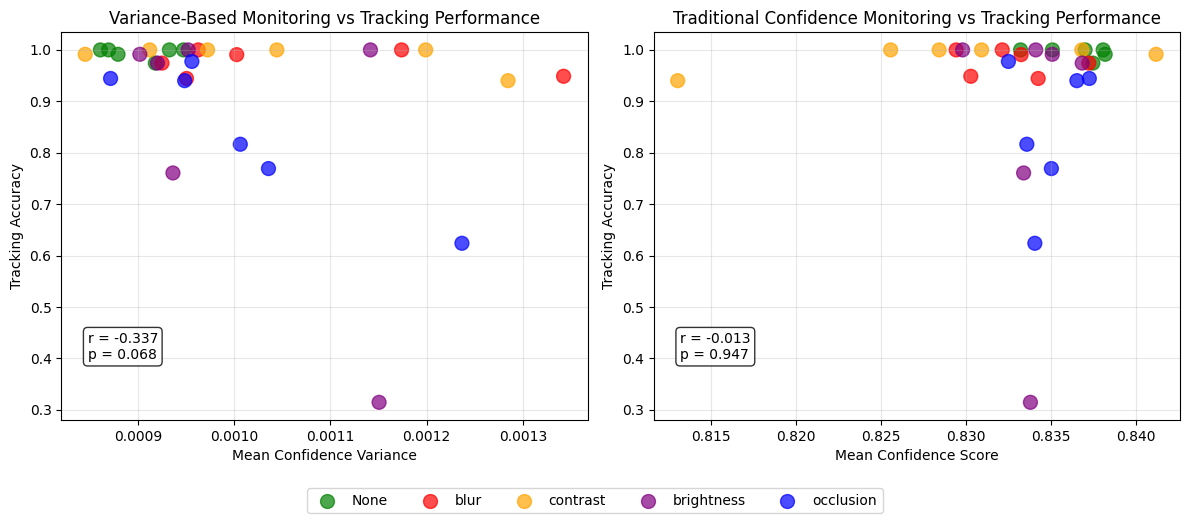

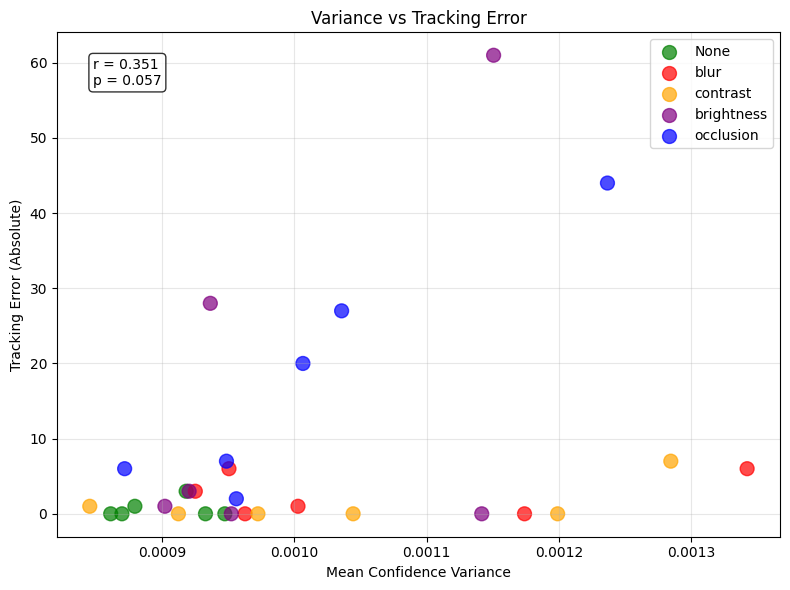


DataFrame saved as: correlation_results.pkl
To reload: df = pd.read_pickle('correlation_results.pkl')

ANALYSIS BY AUGMENTATION TYPE

NONE clips (n=6):
  Mean tracking accuracy:   0.994 (±0.010)
  Mean tracking count:      108.8 (±10.4)
  Mean variance:            0.000901 (±0.000036)
  Mean confidence:          0.837 (±0.002)
  Detection CV (stability): 0.093 (±0.069)

BLUR clips (n=6):
  Mean tracking accuracy:   0.976 (±0.025)
  Mean tracking count:      111.2 (±11.7)
  Mean variance:            0.001060 (±0.000165)
  Mean confidence:          0.833 (±0.003)
  Detection CV (stability): 0.093 (±0.069)

CONTRAST clips (n=6):
  Mean tracking accuracy:   0.989 (±0.024)
  Mean tracking count:      108.2 (±10.1)
  Mean variance:            0.001043 (±0.000170)
  Mean confidence:          0.829 (±0.010)
  Detection CV (stability): 0.095 (±0.070)

BRIGHTNESS clips (n=6):
  Mean tracking accuracy:   0.840 (±0.274)
  Mean tracking count:      114.3 (±19.9)
  Mean variance:            0.00100

In [6]:
from ultralytics import YOLO


# Load your trained model
model_path = "runs/detect/meatball_yolo/weights/best.pt"  # Update this to your model path

clips = [
    "../data/raw/UncertaintyClips/clip_0017.mp4",
    "../data/raw/UncertaintyClips/clip_0018.mp4",
    "../data/raw/UncertaintyClips/clip_0019.mp4",
    "../data/raw/UncertaintyClips/clip_0020.mp4",
    "../data/raw/UncertaintyClips/clip_0021.mp4",
    "../data/raw/UncertaintyClips/clip_0022.mp4",
    "../data/raw/UncertaintyClips/clip_0023.mp4",
    "../data/raw/UncertaintyClips/clip_0024.mp4",
    "../data/raw/UncertaintyClips/clip_0025.mp4",
    "../data/raw/UncertaintyClips/clip_0026.mp4",
    "../data/raw/UncertaintyClips/clip_0027.mp4",
    "../data/raw/UncertaintyClips/clip_0028.mp4",
    "../data/raw/UncertaintyClips/clip_0029.mp4",
    "../data/raw/UncertaintyClips/clip_0030.mp4",
    "../data/raw/UncertaintyClips/clip_0031.mp4",
    "../data/raw/UncertaintyClips/clip_0032.mp4",
    "../data/raw/UncertaintyClips/clip_0033.mp4",
    "../data/raw/UncertaintyClips/clip_0034.mp4",
    "../data/raw/UncertaintyClips/clip_0035.mp4",
    "../data/raw/UncertaintyClips/clip_0036.mp4",
    "../data/raw/UncertaintyClips/clip_0037.mp4",
    "../data/raw/UncertaintyClips/clip_0038.mp4",
    "../data/raw/UncertaintyClips/clip_0039.mp4",
    "../data/raw/UncertaintyClips/clip_0040.mp4",
    "../data/raw/UncertaintyClips/clip_0041.mp4",
    "../data/raw/UncertaintyClips/clip_0042.mp4",
    "../data/raw/UncertaintyClips/clip_0043.mp4",
    "../data/raw/UncertaintyClips/clip_0044.mp4",
    "../data/raw/UncertaintyClips/clip_0045.mp4",
    "../data/raw/UncertaintyClips/clip_0046.mp4",
]


true_counts = [
    109, 108, 117, 117, 117, 89,  # counts for original good clips
    109, 108, 117, 117, 117, 89,  # same counts for degraded versions
    109, 108, 117, 117, 117, 89,  # same counts for degraded versions
    109, 108, 117, 117, 117, 89,  # same counts for degraded versions
    109, 108, 117, 117, 117, 89,  # same counts for degraded versions
]

augmentation_labels = [
    'None', 'None', 'None', 'None', 'None', 'None',  # good clips
    'blur', 'blur', 'blur', 'blur', 'blur', 'blur',  # bad clips
    'contrast', 'contrast', 'contrast', 'contrast', 'contrast', 'contrast',  # bad clips
    'brightness', 'brightness', 'brightness', 'brightness', 'brightness', 'brightness', # bad clips
    'occlusion', 'occlusion', 'occlusion', 'occlusion', 'occlusion', 'occlusion', # bad clips
]


# Run the test
results_df, correlations = main_test_loop(clips, true_counts, augmentation_labels, model_path)